In [96]:
import sys
sys.path.append("../")
sys.path.append("../Modules/")

from analysis import CellGraph, DataReader
from analysis import CurrentTrace

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import correlate
from statsmodels.tsa.arima.model import ARIMA

In [36]:
SIM_DIRECTORY_PREFIX = "../scripts/SkeletonCell.Hay-18-03-2024-20-43-17"
NEXUS_INDEX = 380
SOMA_INDEX = 0
SIM_TIME = 2000

seeds = [123, 124, 125]

## Cross-Correlation Analysis

In [37]:
ccm_nexus = []
ccm_basal = []

for seed in seeds:
    sim_directory = os.path.join(SIM_DIRECTORY_PREFIX, str(seed))

    # Read data
    v = DataReader.read_data(sim_directory, "v")
    adj_matrix = np.loadtxt(os.path.join(sim_directory, "adj_matrix.txt"))
    seg_data = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))

    # Compute axial currents
    ac_matrix = CurrentTrace.compute_axial_currents(v, seg_data, adj_matrix)

    # Find indexes of apical branches (= nexus's children)
    apical_branches = np.where(adj_matrix[NEXUS_INDEX, :] == 1)[0]
    
    # Compute correlations between currents
    cross_corr_matrix = np.zeros((len(apical_branches), len(apical_branches), SIM_TIME))
    for i in range(len(apical_branches)):
        for j in range(len(apical_branches)):
            cross_corr_matrix[i, j] = correlate(ac_matrix[apical_branches[i]], ac_matrix[apical_branches[j]])[SIM_TIME-1:]
    ccm_nexus.append(cross_corr_matrix)

    # Find indexes of soma's children
    soma_children = np.where(adj_matrix[SOMA_INDEX, :] == 1)[0]
    basal_branches = seg_data.iloc[soma_children]
    basal_branches = basal_branches[basal_branches.section == "dend"].index

    cross_corr_matrix = np.zeros((len(basal_branches), len(basal_branches), SIM_TIME))
    for i in range(len(basal_branches)):
        for j in range(len(basal_branches)):
            cross_corr_matrix[i, j] = correlate(ac_matrix[basal_branches[i]], ac_matrix[basal_branches[j]])[SIM_TIME-1:]
    ccm_basal.append(cross_corr_matrix)

In [34]:
ccm_nexus_all = np.stack(ccm_nexus)
np.argmax(np.mean(ccm_nexus_all, axis = 0), axis = -1)

array([[  0, 182, 251],
       [991,   0,   0],
       [541,   1,   0]])

In [38]:
ccm_soma_all = np.stack(ccm_basal)
np.argmax(np.mean(ccm_soma_all, axis = 0), axis = -1)

array([[   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    3,    0,  233, 1422],
       [   0,    0,    0,    0,    3,    0,  608,  465],
       [   1,    1,    2,    3,    0,    2,    0,    0],
       [   0,    0,    0,    0, 1767,    0,    0,  506],
       [   0,    0,    1,    1,    0,    0,    0,    0],
       [   0,    0,  428,    1,    0,  227,    0,    0]])

## ARIMA Analysis

In [87]:
# https://stats.stackexchange.com/questions/93540/testing-equality-of-coefficients-from-two-different-regressions
Z_nexus = []
Z_basal = []

for seed in seeds:
    sim_directory = os.path.join(SIM_DIRECTORY_PREFIX, str(seed))

    # Read data
    v = DataReader.read_data(sim_directory, "v")
    adj_matrix = np.loadtxt(os.path.join(sim_directory, "adj_matrix.txt"))
    seg_data = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))

    # Compute axial currents
    ac_matrix = CurrentTrace.compute_axial_currents(v, seg_data, adj_matrix)

    # Find indexes of apical branches (= nexus's children)
    apical_branches = np.where(adj_matrix[NEXUS_INDEX, :] == 1)[0]
    
    # Estimate ARIMAs between currents
    Z_matrix = np.zeros((len(apical_branches), len(apical_branches), 5))
    for i in range(len(apical_branches)):
        for j in range(len(apical_branches)):
            model1 = ARIMA(ac_matrix[apical_branches[i]], order = (2, 0, 2))
            res1 = model1.fit()
            model2 = ARIMA(ac_matrix[apical_branches[j]], order = (2, 0, 2))
            res2 = model2.fit()
            Z = (res1.params - res2.params) / np.sqrt(np.diag(res1.cov_params()) + np.diag(res2.cov_params()))
            Z_matrix[i, j] = Z[:-1]
    Z_nexus.append(Z_matrix)

    # Find indexes of soma's children
    soma_children = np.where(adj_matrix[SOMA_INDEX, :] == 1)[0]
    basal_branches = seg_data.iloc[soma_children]
    basal_branches = basal_branches[basal_branches.section == "dend"].index

    Z_matrix = np.zeros((len(basal_branches), len(basal_branches), 5))
    for i in range(len(basal_branches)):
        for j in range(len(basal_branches)):
            model1 = ARIMA(ac_matrix[basal_branches[i]], order = (2, 0, 2))
            res1 = model1.fit()
            model2 = ARIMA(ac_matrix[basal_branches[j]], order = (2, 0, 2))
            res2 = model2.fit()
            Z = (res1.params - res2.params) / np.sqrt(np.diag(res1.cov_params()) + np.diag(res2.cov_params()))
            Z_matrix[i, j] = Z[:-1]
    Z_basal.append(Z_matrix)

/opt/anaconda3/envs/simulations/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/simulations/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/simulations/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/simulations/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary sta

In [89]:
Z_nexus_all = np.stack(Z_nexus)
Z_nexus_all_avg = np.mean(Z_nexus_all, axis = 0)
np.sum(np.abs(Z_nexus_all_avg) < 1.96, axis = -1) / 5

array([[1. , 0.2, 0.6],
       [0.2, 1. , 1. ],
       [0.6, 1. , 1. ]])

In [90]:
Z_basal_all = np.stack(Z_basal)
Z_basal_all_avg = np.mean(Z_basal_all, axis = 0)
np.sum(np.abs(Z_basal_all_avg) < 1.96, axis = -1) / 5

array([[1. , 1. , 0.2, 0.2, 0. , 0.2, 0.2, 0.6],
       [1. , 1. , 1. , 1. , 0.8, 0.8, 1. , 0.8],
       [0.2, 1. , 1. , 1. , 0.2, 0.2, 0.8, 0.2],
       [0.2, 1. , 1. , 1. , 0.2, 0.2, 1. , 0.4],
       [0. , 0.8, 0.2, 0.2, 1. , 0.8, 0.2, 0.6],
       [0.2, 0.8, 0.2, 0.2, 0.8, 1. , 0.2, 0.4],
       [0.2, 1. , 0.8, 1. , 0.2, 0.2, 1. , 0.4],
       [0.6, 0.8, 0.2, 0.4, 0.6, 0.4, 0.4, 1. ]])

## Magnitude Analysis

In [97]:
magn_apic = []
magn_apic_trunk = []
magn_basal = []

for seed in seeds:
    sim_directory = os.path.join(SIM_DIRECTORY_PREFIX, str(seed))

    # Read data
    v = DataReader.read_data(sim_directory, "v")
    adj_matrix = np.loadtxt(os.path.join(sim_directory, "adj_matrix.txt"))
    seg_data = pd.read_csv(os.path.join(sim_directory, "segment_data.csv"))

    # Compute axial currents
    ac_matrix = CurrentTrace.compute_axial_currents(v, seg_data, adj_matrix)

    # Find indexes of apical branches (= nexus's children)
    apical_branches = np.where(adj_matrix[NEXUS_INDEX, :] == 1)[0]
    magn_apic.append(np.abs(ac_matrix[apical_branches]))
    
    # Find indexes of soma's children
    soma_children = np.where(adj_matrix[SOMA_INDEX, :] == 1)[0]
    basal_branches = seg_data.iloc[soma_children]
    basal_branches = basal_branches[basal_branches.section == "dend"].index
    magn_basal.append(np.abs(ac_matrix[basal_branches]))

    apic_trunk = seg_data.iloc[soma_children]
    apic_trunk = apic_trunk[apic_trunk.section == "apic"].index
    magn_apic_trunk.append(np.abs(ac_matrix[apic_trunk]))

In [98]:
magn_apic_all = np.stack(magn_apic)
magn_apic_trunk_all = np.stack(magn_apic_trunk)
magn_basal_all = np.stack(magn_basal)

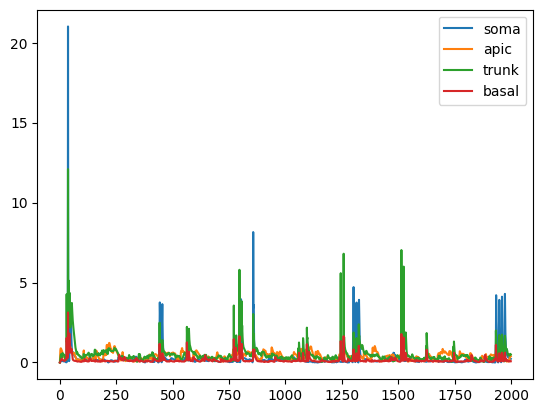

In [115]:
plt.plot(np.abs(ac_matrix[0]), label = 'soma')
plt.plot(np.sum(np.mean(magn_apic_all, axis = 0), axis = 0), label = 'apic')
plt.plot(np.sum(np.mean(magn_apic_trunk_all, axis = 0), axis = 0), label = 'trunk')
plt.plot(np.sum(np.mean(magn_basal_all, axis = 0), axis = 0), label = 'basal')
plt.legend()

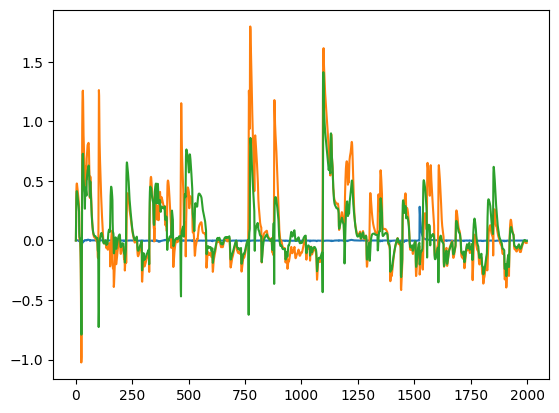

In [53]:
plt.plot(ac_matrix[381])
plt.plot(ac_matrix[393])
plt.plot(ac_matrix[422])

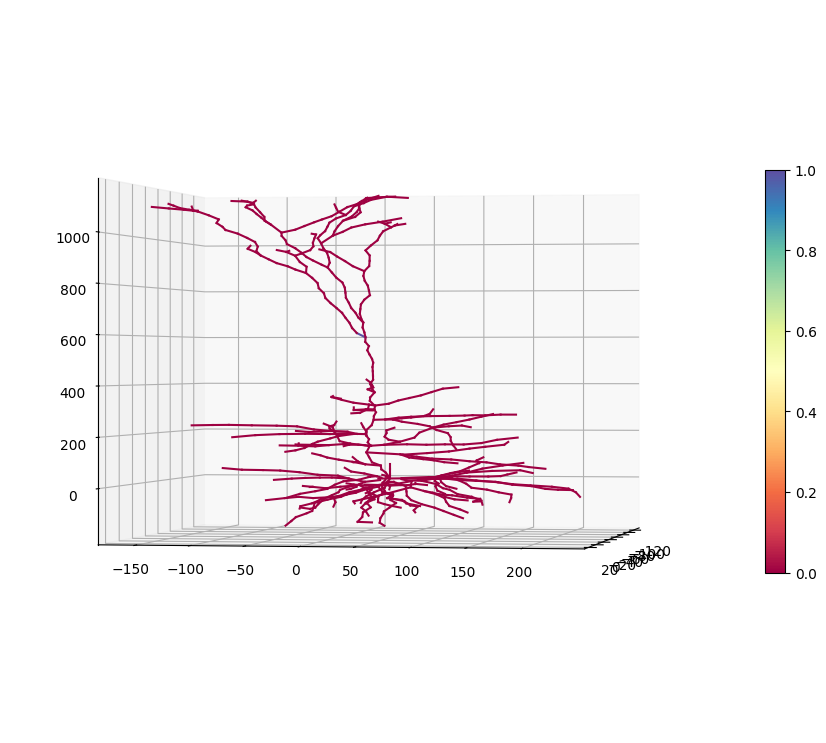

In [119]:
cg = CellGraph(seg_data)
colors = np.zeros(len(seg_data))
colors[NEXUS_INDEX] = 1
fig = cg.plot_cell(color = colors)
plt.figsize = (10, 30)
ax = fig.gca()
ax.view_init(elev = 0, azim = 10)